In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

= Exercice 5

In [16]:
def generate_gmm_data(n_per_cluster, d, K, separation=1.0, seed=42):
    """
    Generate data from a K-component isotropic Gaussian mixture 
    in dimension d.
    """
    rng = np.random.RandomState(seed)
    
    # Generate K random centroid directions in R^d
    # When d >= K, use QR for orthogonal directions
    # When d < K, just use random directions (they can't all be orthogonal)
    M = rng.randn(K, d)
    if d >= K:
        Q, _ = np.linalg.qr(M.T)          # (d, K)
        centroids = Q[:, :K].T * separation #* np.sqrt(d)  # (K, d)
    else:
        # Normalise each row then scale
        norms = np.linalg.norm(M, axis=1, keepdims=True)
        centroids = (M / norms) * separation #* np.sqrt(d)
    
    X_list, y_list = [], []
    for k in range(K):
        X_k = rng.randn(n_per_cluster, d) + centroids[k, :]
        X_list.append(X_k)
        y_list.append(np.full(n_per_cluster, k))
    
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    idx = rng.permutation(len(y))
    return X[idx], y[idx]

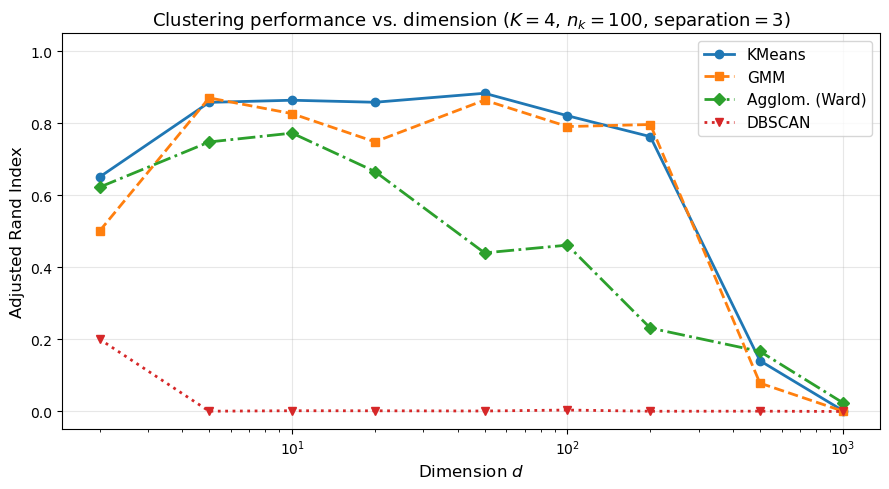

  Dim           KMeans              GMM   Agglom. (Ward)           DBSCAN
-------------------------------------------------------------------------
    2            0.651            0.500            0.622            0.200
    5            0.858            0.871            0.748           -0.000
   10            0.864            0.827            0.773            0.001
   20            0.858            0.748            0.666            0.001
   50            0.883            0.864            0.440            0.000
  100            0.821            0.791            0.461            0.003
  200            0.763            0.797            0.231           -0.000
  500            0.140            0.078            0.166           -0.000
 1000            0.001            0.000            0.023           -0.001


In [20]:
# ----- Experiment: ARI vs dimension for all algorithms -----
dims = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
K = 4
n_per_cluster = 100
separation = 3 

results = {name: [] for name in 
           ['KMeans', 'GMM', 'Agglom. (Ward)', 'DBSCAN']}

for d in dims:
    X, y_true = generate_gmm_data(n_per_cluster, d, K, 
                                   separation=separation, seed=42)
    
    # k-means
    km = KMeans(n_clusters=K, n_init=10, random_state=0).fit(X)
    results['KMeans'].append(adjusted_rand_score(y_true, km.labels_))
    
    # GMM (EM)
    cov_type = 'diag' if d >= 50 else 'full'
    gmm = GaussianMixture(n_components=K, covariance_type=cov_type,
                          n_init=5, random_state=0).fit(X)
    results['GMM'].append(adjusted_rand_score(y_true, gmm.predict(X)))
    
    # Agglomerative (Ward)
    agg = AgglomerativeClustering(n_clusters=K, linkage='ward').fit(X)
    results['Agglom. (Ward)'].append(
        adjusted_rand_score(y_true, agg.labels_))
    
    # DBSCAN — adaptive eps using k-distance heuristic
    k_nn = 2 #* d  # scale neighbors with dimension
    k_nn = min(k_nn, len(X) - 1)
    nn = NearestNeighbors(n_neighbors=min(10, k_nn)).fit(X)
    dists, _ = nn.kneighbors(X)
    eps = np.percentile(dists[:, -1], 90)
    db = DBSCAN(eps=eps, min_samples=5).fit(X)
    results['DBSCAN'].append(adjusted_rand_score(y_true, db.labels_))

# ----- Plot -----
plt.figure(figsize=(9, 5))
markers = ['o-', 's--', 'D-.', 'v:']
for (name, ari_list), marker in zip(results.items(), markers):
    plt.plot(dims, ari_list, marker, label=name, linewidth=2, 
             markersize=6)

plt.xlabel('Dimension $d$', fontsize=12)
plt.ylabel('Adjusted Rand Index', fontsize=12)
plt.title(f'Clustering performance vs. dimension '
          f'($K={K}$, $n_k={n_per_cluster}$, '
          f'separation$={separation}$)', fontsize=13)
plt.xscale('log')
plt.ylim(-0.05, 1.05)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----- Print summary table -----
print(f"{'Dim':>5}", end="")
for name in results:
    print(f"  {name:>15}", end="")
print()
print("-" * (5 + 17 * len(results)))
for i, d in enumerate(dims):
    print(f"{d:>5}", end="")
    for name in results:
        print(f"  {results[name][i]:>15.3f}", end="")
    print()
